# 自訂的輸入層及辨識層(Dense)

## 載入套件

In [1]:
import tensorflow as tf
from tensorflow.keras.applications.resnet_v2 import ResNet152V2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras.applications.resnet_v2 import decode_predictions
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import numpy as np

## 步驟1：載入 Flower 資料

In [9]:
# 資料集來源：https://www.tensorflow.org/tutorials/load_data/images

# 參數設定
batch_size = 64
img_height = 224
img_width = 224
data_dir = './flower_photos/'

# 載入 Flower 訓練資料
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# 載入 Flower 驗證資料
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


## 步驟2：進行特徵工程，將特徵縮放成(0, 1)之間

In [11]:
from tensorflow.keras import layers

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
normalized_val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

## 顯示 ResNet152V2 完整的模型結構

In [30]:
base_model = ResNet152V2(weights='imagenet')
print(base_model.summary())

Model: "resnet152v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
________________________________________________________________________________________

In [31]:
len(base_model.layers)

566

## 步驟3：建立模型結構

In [32]:
# 預先訓練好的模型 -- ResNet152V2
base_model = ResNet152V2(weights='imagenet', include_top=False)
print(base_model.summary())

# 加上自訂的辨識層(Dense)
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(10, activation='softmax')(x)

# 指定自訂的輸入層及辨識層(Dense)
model = Model(inputs=base_model.input, outputs=predictions)

# 模型前段不需訓練了
for layer in base_model.layers:
    layer.trainable = False

# 設定優化器(optimizer)、損失函數(loss)、效能衡量指標(metrics)的類別
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

Model: "resnet152v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, None, None, 6 0           conv1_conv[0][0]                 
________________________________________________________________________________________

In [33]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, None, None, 6 0           conv1_conv[0][0]                 
____________________________________________________________________________________________

## 步驟5：模型訓練

In [34]:
# 設定快取(cache)、prefetch，以增進訓練效率
AUTOTUNE = tf.data.AUTOTUNE
normalized_ds = normalized_ds.cache().prefetch(buffer_size=AUTOTUNE)
normalized_val_ds = normalized_val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# 模型訓練
history = model.fit(normalized_ds, validation_data = normalized_val_ds, epochs=5)

Epoch 1/5
46/46 [==============================] - 65s 1s/step - loss: 1.1907 - accuracy: 0.5677 - val_loss: 0.4980 - val_accuracy: 0.8283
Epoch 2/5
46/46 [==============================] - 55s 1s/step - loss: 0.4272 - accuracy: 0.8449 - val_loss: 0.4105 - val_accuracy: 0.8569
Epoch 3/5
46/46 [==============================] - 55s 1s/step - loss: 0.3125 - accuracy: 0.8896 - val_loss: 0.3798 - val_accuracy: 0.8719
Epoch 4/5
46/46 [==============================] - 55s 1s/step - loss: 0.2518 - accuracy: 0.9162 - val_loss: 0.3665 - val_accuracy: 0.8760
Epoch 5/5
46/46 [==============================] - 55s 1s/step - loss: 0.2113 - accuracy: 0.9333 - val_loss: 0.3610 - val_accuracy: 0.8774


## 步驟6：繪製訓練時準確率/損失函數的變化

In [35]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

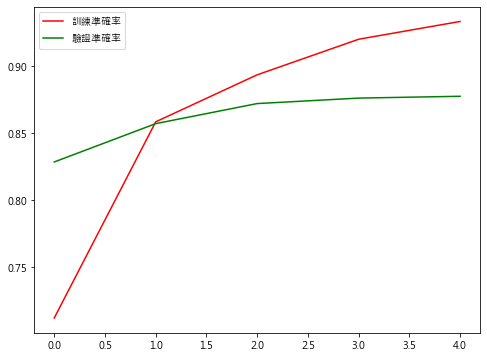

In [36]:
# 對訓練過程的準確率繪圖
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], 'r', label='訓練準確率')
plt.plot(history.history['val_accuracy'], 'g', label='驗證準確率')
plt.xlabel('Epoch')
plt.ylabel('準確率')
plt.legend()

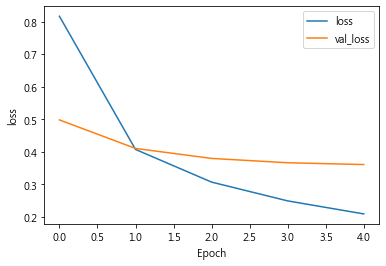

In [37]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='訓練損失')
plt.plot(history.history['val_loss'], label = '驗證損失')
plt.xlabel('Epoch')
plt.ylabel('損失')
plt.legend()

## 步驟7：預測

In [10]:
# 顯示辨識的類別
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [25]:
# 任選一張圖片，例如玫瑰
img_path = './images_test/rose.png'
# 載入圖檔，並縮放寬高為 (224, 224) 
img = image.load_img(img_path, target_size=(224, 224))

# 加一維，變成 (1, 224, 224, 3)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# 預測
preds = model.predict(x)

# 顯示預測結果
y_pred = [round(i * 100, 2) for i in preds[0]]
print(f'預測機率(%)：{y_pred}')
print(f'預測類別：{class_names[np.argmax(preds)]}')

預測機率(%)：[0.03, 0.0, 99.78, 0.04, 0.15, 0.0, 0.0, 0.0, 0.0, 0.0]
預測類別：roses


In [29]:
# 任選一張圖片，例如雛菊
img_path = './images_test/daisy2.jpg'
# 載入圖檔，並縮放寬高為 (224, 224) 
img = image.load_img(img_path, target_size=(224, 224))

# 加一維，變成 (1, 224, 224, 3)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# 預測
preds = model.predict(x)

# 顯示預測結果
y_pred = [round(i * 100, 2) for i in preds[0]]
print(f'預測機率(%)：{y_pred}')
print(f'預測類別：{class_names[np.argmax(preds)]}')

預測機率(%)：[55.75, 36.61, 0.93, 5.17, 1.54, 0.0, 0.0, 0.0, 0.0, 0.0]
預測類別：daisy
